###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c)2014 L.A. Barba, G.F. Forsyth, C.D. Cooper. Partly based on content  by David Ketcheson, also under CC-BY.

# Phugoid model: bonus!

_The phugoid model of glider flight_ has been such a fun problem to showcase the power of numerical solution of differential equations, we thought you'd enjoy a bonus notebook. The previous lessons were:

* [Phugoid motion](https://nbviewer.jupyter.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/01_phugoid/01_01_Phugoid_Theory.ipynb) —Lays the groundwork for our fun problem, with some context, a little history and a description of the physics of phugoids: curves representing the trajectory of a glider exchanging potential and kinetic energy, with no drag.
* [Phugoid oscillation](https://nbviewer.jupyter.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/01_phugoid/01_02_Phugoid_Oscillation.ipynb) —Develops the simple harmonic motion of an aircraft experiencing a small perturbation from the horizontal trajectory: our opportunity to introduce Euler's method, and study its convergence via an exact solution.
* [Full phugoid motion](https://nbviewer.jupyter.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/01_phugoid/01_03_PhugoidFullModel.ipynb) —The full model takes into account the force of drag and results in a system of two nonlinear equations. We obtain the trajectories using Euler's method in vectorized form, introduce grid-convergence analysis and finish with the paper-airplane challenge!

That is a fantastic foundation for numerical methods. It's a good time to complement it with some theory: the first screencast of the course uses Taylor series to show that _Euler's method is a first-order method_, and we also show you graphical interpretations. Many problems require a more accurate method, though: second order or higher. Among the most popular higher-order methods that we can mention are the _Runge-Kutta methods_, developed around 1900: more than 100 years after Euler published his book containing the method now named after him!

### Euler's method is a first-order method

In this screencast, we use a Taylor series expansion to analyze Euler's method and show that it incurs a truncation error of first order. We also use a graphical interpretation to motivate the _modified_ Euler method, which achieves second order.

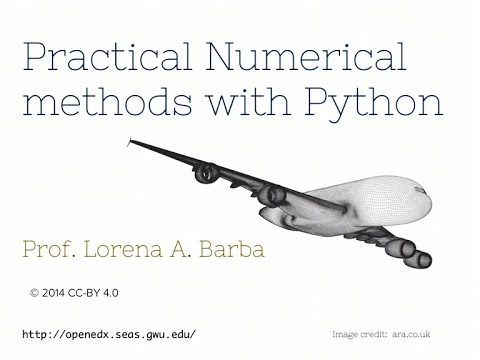

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('6i6qhqDCViA')

## Second-order methods

The notebook on phugoid oscillation (lesson 2) included a study of the accuracy obtained with Euler's method, using the exact solution for the simple harmonic motion. We made a _convergence plot_ and saw that as $\Delta t$ gets smaller, the error also gets smaller. 

We could have drawn a line with a slope equal to 1 on that log-log plot, and you would have seen that it was parallel to the convergence line. A slope equal to 1 on a log-log convergence plot is an indication that we have a first-order method: the error scales as ${\mathcal O}(\Delta t)$. 

In lesson 3, using the full phugoid model (which is nonlinear and does not have an exact solution), we did a _grid-convergence study_ with three different grids, and obtained the _observed_ order of convergence—it was very close to 1, indicating a slope of 1 on a log-log plot.

Another way to look at an ${\mathcal O}(\Delta t)$ method is to say that the error scales _linearly_ with the step size, or that they are proportional:

$$
e \propto \Delta t
$$

where $e$ stands for the error. To get more accuracy, we could use a _second-order_ method, in which the error is ${\mathcal O}(\Delta t^2)$. In general, we say that a method is of order $p$ when the error is proportional to $(\Delta t)^p$.

In the screencast titled "Euler's method is a first-order method," we used a graphical interpretation to get an idea for improving it: by estimating an intermediate point, like the **midpoint**, we can get a better approximation of the area under the curve of $u^\prime$. The scheme has two steps and is written as:

$$
\begin{align}
u_{n+1/2}   & = u_n + \frac{\Delta t}{2} f(u_n) \\
u_{n+1} & = u_n + \Delta t \,\, f(u_{n+1/2})
\end{align}
$$

This method is known as the *explicit midpoint method* or the *modified Euler method*, and it is a second-order method. Notice that we had to apply the right-hand side, $~f(u)$, twice. This idea can be extended: we could imagine estimating additional points between $u_{n}$ and $u_{n+1}$ and evaluating $~f(u)$ at the intermediate points to get higher accuracy—that's the idea behind Runge-Kutta methods.

### Runge-Kutta methods

In the modified Euler method, we improve the accuracy over Euler's method by evaluating the right-hand side of the differential equation at an intermediate point: the midpoint. The same idea can be applied again, and the function $f(u)$ can be evaluated at more intermediate points, improving the accuracy even more. This is the basis of the famous *Runge-Kutta (RK) methods*, going back to Carl Runge and Martin Kutta. The modified Euler method corresponds to _second-order_ Runge-Kutta.

Here's a bit of historical coincidence that will blow your mind: Carl Runge's daughter Iris—an accomplished applied mathematician in her own right—worked assiduously over the summer of 1909 to translate Lanchester's _"Aerodonetics."_ She also reproduced his graphical method to draw the phugoid curves (Tobies, 2012).

### Phugoid model with 2nd-order RK

Let's compute the motion of a glider under the full phugoid model using the second-order Runge-Kutta method. We'll build on the _paper airplane challenge_ of lesson 3 now, and look for the horizontal distance that the plane travels until the moment it touches the ground. 

As usual, let's start by importing the libraries and modules that we need, and setting up the model parameters. We also set some default plotting formats by modifying entries of the `rcParams` dictionary.

In [2]:
import math
import numpy
from matplotlib import pyplot
%matplotlib inline

In [3]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In the paper-airplane challenge of lesson 3, we suggested an $L/D=5.0$ as a realistic value for paper airplanes, according to experiments, and a trim velocity of 4.9 m/s. Let's start with those values, but you could experiment changing these a bit. _What do you think will happen if you make $L/D$ higher?_

In [4]:
# Set parameters.
g = 9.81  # gravitational acceleration (m.s^{-2})
vt = 4.9  # trim velocity (m.s)
CD = 1.0 / 5.0  # drag coefficient
CL = 1.0  # lift coefficient

# Set initial conditions.
v0 = 6.5  # start at the trim velocity
theta0 = -0.1  # trajectory angle
x0 = 0.0  # horizontal position
y0 = 2.0  # vertical position (altitude)

Among the initial parameters that we suggest for your first experiment, we are starting with a velocity a little higher than the trim velocity, launch the paper airplane with a negative initial angle, and take the initial height to be 2 meters—all sound like reasonable choices.

Now, we can define a few functions to carry out the computation:
* The right-hand side of the phugoid model from [Lesson 3](https://nbviewer.jupyter.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/01_phugoid/01_03_PhugoidFullModel.ipynb),
* One step of the Euler's method that we learned in [Lesson 2](https://nbviewer.jupyter.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/01_phugoid/01_02_Phugoid_Oscillation.ipynb), and
* Differences with respect to a fine grid, as in [Lesson 3](https://nbviewer.jupyter.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/01_phugoid/01_03_PhugoidFullModel.ipynb).

In [5]:
def rhs_phugoid(u, CL, CD, g, vt):
    """
    Returns the right-hand side of the phugoid system of equations.
    
    Parameters
    ----------
    u : list or numpy.ndarray
        Solution at the previous time step
        as a list or 1D array of four floats.
    CL : float
        Lift coefficient.
    CD : float
        Drag coefficient.
    g : float
        Gravitational acceleration.
    vt : float
        Trim velocity.
    
    Returns
    -------
    rhs : numpy.ndarray
        The right-hand side of the system
        as a 1D array of four floats.
    """
    v, theta, x, y = u
    rhs = numpy.array([-g * math.sin(theta) - CD / CL * g / vt**2 * v**2,
                       -g * math.cos(theta) / v + g / vt**2 * v,
                       v * math.cos(theta),
                       v * math.sin(theta)])
    return rhs


def euler_step(u, f, dt, *args):
    """
    Returns the solution at the next time step using Euler's method.
    
    Parameters
    ----------
    u : numpy.ndarray
        Solution at the previous time step
        as a 1D array of floats.
    f : function
        Function to compute the right-hand side of the system.
    dt : float
        Time-step size.
    args : tuple, optional
        Positional arguments to pass to the function f.
    
    Returns
    -------
    u_new : numpy.ndarray
        The solution at the next time step
        as a 1D array of floats.
    """
    u_new = u + dt * f(u, *args)
    return u_new


def l1_diff(u_coarse, u_fine, dt):
    """
    Returns the difference in the L1-norm between the solution on
    a coarse grid and the solution on a fine grid.
    
    Parameters
    ----------
    u_coarse : numpy.ndarray
        Solution on the coarse grid as a 1D array of floats.
    u_fine : numpy.ndarray
        Solution on the fine grid as a 1D array of floats.
    dt : float
        Time-step size.
    
    Returns
    -------
    diff : float
        The difference between the two solution in the L1-norm
        scaled by the time-step size.
    """
    N_coarse = u_coarse.shape[0]
    N_fine = u_fine.shape[0]
    ratio = math.ceil(N_fine / N_coarse)
    diff = dt * numpy.sum(numpy.abs(u_coarse - u_fine[::ratio]))
    return diff

Next, we also need to define the function `rk2_step()` that computes the next time step using the *modified Euler* method of equations $(1)$ and $(2)$, above, otherwise known as 2nd-order Runge-Kutta or RK2. This function will be called over and over again within the time loop.

In [6]:
def rk2_step(u, f, dt, *args):
    """
    Returns the solution at the next time step using 2nd-order
    Runge-Kutta method.
    
    Parameters
    ----------
    u : numpy.ndarray
        Solution at the previous time step
        as a 1D array of floats.
    f : function
        Function to compute the right-hand side of the system.
    dt : float
        Time-step size.
    args : tuple, optional
        Positional arguments to pass to the function f.
    
    Returns
    -------
    u_new : numpy.ndarray
        The solution at the next time step
        as a 1D array of floats.
    """
    u_star = u + 0.5 * dt * f(u, *args)
    u_new = u + dt * f(u_star, *args)
    return u_new

Like in [Lesson 3](https://nbviewer.jupyter.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/01_phugoid/01_03_PhugoidFullModel.ipynb), we first need to set up the time discretization, then initialize arrays to save the solution and we are set to go! The only difference this time is that we are using _both_ Euler's method and 2nd-order Runge-Kutta to get a solution, to compare the two. 

In [7]:
T = 15.0  # length of the time interval
dt = 0.01  # time-step size
N = int(T / dt) + 1  # number of time steps

# Create arrays to store the solution at each time step.
u_euler = numpy.empty((N, 4))
u_rk2 = numpy.empty((N, 4))

# Set the initial conditions.
u_euler[0] = numpy.array([v0, theta0, x0, y0])
u_rk2[0] = numpy.array([v0, theta0, x0, y0])

# Time integration with both method.
for n in range(N - 1):
    u_euler[n + 1] = euler_step(u_euler[n], rhs_phugoid, dt,
                                CL, CD, g, vt)
    u_rk2[n + 1] = rk2_step(u_rk2[n], rhs_phugoid, dt,
                            CL, CD, g, vt)

Now we can get the position of the glider in time, according to both Euler's method and the 2nd-order Runge-Kutta method, by extracting the appropriate portions of the solution arrays:

In [8]:
# Get the glider's position over the time.
x_euler = u_euler[:, 2]
y_euler = u_euler[:, 3]
x_rk2 = u_rk2[:, 2]
y_rk2 = u_rk2[:, 3]

##### How far will it fly before touching the ground?

As the $y$-axis measures the vertical coordinate with respect to the ground, negative values of $y$ don't have any physical meaning: the glider would have hit the ground by then! To find out if there are any negative $y$ values we can use the handy function [`numpy.where`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html). This function returns the **indices** of the elements in an array that match a given condition. For example, `numpy.where(y_euler<0)[0]` gives an array of the indices `i` where `y_euler[i]<0` (the `[0]` is necessary as `numpy.where` returns an array, which in this case contains a single line). If no elements of the array match the condition, the array of indices comes out empty. 

From the physical problem, we know that once there is one negative value, the glider has hit the ground and all the remaining time-steps are unphysical. Therefore, we are interested in finding the _first_ index where the condition applies, given by `numpy.where(y_euler<0)[0][0]`—do read the  documentation of the function if you need to! 

In [9]:
# Get the index of the first negative element of y_euler.
idx_negative_euler = numpy.where(y_euler < 0.0)[0]
if len(idx_negative_euler) == 0:
    idx_ground_euler = N - 1
    print('[Euler] Glider has not touched ground yet!')
else:
    idx_ground_euler = idx_negative_euler[0]
# Get the index of the first negative element of y_rk2.
idx_negative_rk2 = numpy.where(y_rk2 < 0.0)[0]
if len(idx_negative_rk2) == 0:
    idx_ground_rk2 = N - 1
    print('[RK2] Glider has not touched ground yet!')
else:
    idx_ground_rk2 = idx_negative_rk2[0]

##### Do Euler and RK2 produce the same solution?

An easy way to compare the numerical results obtained with the Euler and 2nd-order Runge-Kutta methods is using [`numpy.allclose`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.allclose.html). This function compares each element of two arrays and returns `True` if each comparison is within some relative tolerance. Here, we use the default tolerance: $10^{-5}$.

In [10]:
# Check if to two scheme leads to the same numerical solution.
print('Are the x-values close? {}'.format(numpy.allclose(x_euler, x_rk2)))
print('Are the y-values close? {}'.format(numpy.allclose(y_euler, y_rk2)))

Are the x-values close? False
Are the y-values close? False


Hmmm, they do differ. Maybe $10^{-5}$ is too tight a tolerance, considering we're using a somewhat coarse grid with first- and second-order methods. Perhaps we can assess this visually, by plotting the glider's path? Study the code below, where we are plotting the path twice, taking a closer look in the second plot by "zooming in" to the beginning of the flight.

Distance traveled: 14.516


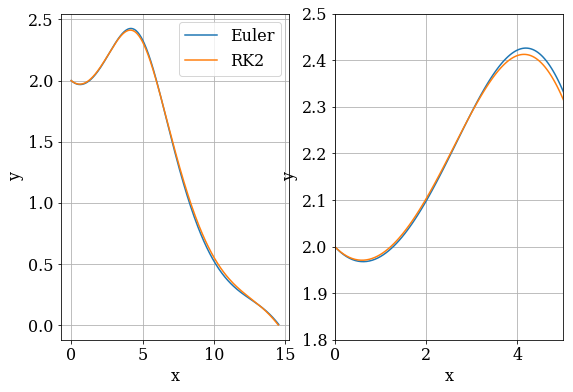

In [11]:
print('Distance traveled: {:.3f}'.format(x_rk2[idx_ground_rk2 - 1]))

# Plot the glider's path for both schemes.
pyplot.figure(figsize=(9.0, 6.0))
pyplot.subplot(121)
pyplot.grid()
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.plot(x_euler[:idx_ground_euler], y_euler[:idx_ground_euler],
            label='Euler')
pyplot.plot(x_rk2[:idx_ground_rk2], y_rk2[:idx_ground_rk2],
            label='RK2')
pyplot.legend();
# Let's take a closer look!
pyplot.subplot(122)
pyplot.grid()
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.plot(x_euler, y_euler, label='Euler')
pyplot.plot(x_rk2, y_rk2, label='RK2')
pyplot.xlim(0.0, 5.0)
pyplot.ylim(1.8, 2.5);

From far away, the Euler and RK2 methods seem to be producing similar answers. However, if we take a closer look, small differences become evident. Keep in mind that we are solving the same equation and both methods will converge to the same solution as we refine the grid. However, they converge to that solution at different rates: RK2 gets more accurate faster, as you make $\Delta t$ smaller.

### Grid-convergence

Just like in [Lesson 3](https://nbviewer.jupyter.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/01_phugoid/01_03_PhugoidFullModel.ipynb), we want to do a grid-convergence study with RK2, to see if we indeed observe the expected rate of convergence. It is always an important step in a numerical solution to investigate whether the method is behaving the way we expect it to: this needs to be confirmed experimentally for every new problem we solve and for every new method we apply!

In the code below, a `for`-loop computes the solution on different time grids, with the coarsest and finest grid differing by 100x. We can use the difference between solutions to investigate convergence, as before.

In [12]:
# Set the list of time-step sizes to investigate.
dt_values = [0.1, 0.05, 0.01, 0.005, 0.001]

# Create an empty list to store the solution for each time-step size.
u_values = []

for dt in dt_values:
    N = int(T / dt) + 1  # number of time steps
    # Set initial conditions.
    u = numpy.empty((N, 4))
    u[0] = numpy.array([v0, theta0, x0, y0])
    # Time integration using RK2 method.
    for n in range(N - 1):
        u[n + 1] = rk2_step(u[n], rhs_phugoid, dt, CL, CD, g, vt)
    u_values.append(u)

Once those runs are done, we compute the difference between each numerical solution and the fine-grid solution.

In [13]:
# Compute the differences in the x-position for all grids.
diff_values = []
for u, dt in zip(u_values, dt_values):
    diff = l1_diff(u[:, 2], u_values[-1][:, 2], dt)
    diff_values.append(diff)

And now we plot!

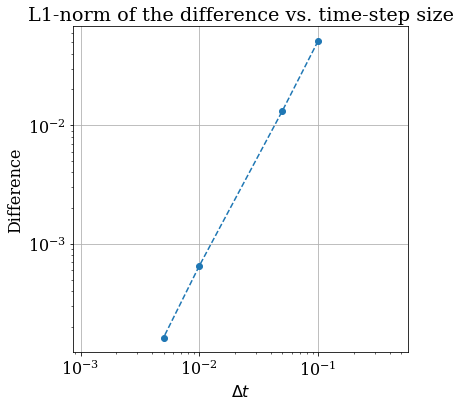

In [14]:
# Plot difference versus the time-step size.
pyplot.figure(figsize=(6.0, 6.0))
pyplot.title('L1-norm of the difference vs. time-step size')
pyplot.xlabel('$\Delta t$')
pyplot.ylabel('Difference')
pyplot.grid()
pyplot.loglog(dt_values[:-1], diff_values[:-1],
              color='C0', linestyle='--', marker='o')
pyplot.axis('equal');

This is looking good! The difference relative to our fine-grid solution is decreasing with the mesh size at a faster rate than in [Lesson 3](https://nbviewer.jupyter.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/01_phugoid/01_03_PhugoidFullModel.ipynb), but *how much faster?* When we computed the observed order of convergence with Euler's method, we got a value close to 1—it's a first-order method. Can you guess what we'll get now with RK2?

To compute the observed order of convergence, we use three grid resolutions that are refined at a constant rate, in this case $r=2$. 

In [15]:
r = 2  # time-step size refinement ratio
h = 0.001  # finest time-step size

dt_values = [h, r * h, r**2 * h]
u_values = []

for dt in dt_values:
    N = int(T / dt) + 1  # number of time steps
    # Set initial conditions.
    u = numpy.empty((N, 4))
    u[0] = numpy.array([v0, theta0, x0, y0])
    # Time integration using RK2.
    for n in range(N - 1):
        u[n + 1] = rk2_step(u[n], rhs_phugoid, dt, CL, CD, g, vt)
    # Store the solution for the present time grid.
    u_values.append(u)

# Compute the observed order of convergence.
p = (math.log(l1_diff(u_values[2], u_values[1], dt_values[2]) /
              l1_diff(u_values[1], u_values[0], dt_values[1])) /
     math.log(r))

print('Observed order of convergence: p = {:.3f}'.format(p))

Observed order of convergence: p = 1.996


Probably you're not too surprised to see that the observed order of convergence is close to $2$. Because we used a second-order method! This means that the numerical solution is converging with the grid resolution twice as fast compared with Euler's method in [Lesson 3](https://nbviewer.jupyter.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/01_phugoid/01_03_PhugoidFullModel.ipynb), or in other words, the error scales as ${\mathcal O}(\Delta t^2)$. That is a lot faster! However, we are paying a price here: second-order Runge-Kutta requires more computations per iteration.

##### Challenge task

How much longer does it take to get the solution with RK2, compared to Euler's method? Run the same solution (same time grid, same parameters), but find a way to *time* the calculation with Python, and compare the runtimes.

## Multi-step methods

The screencast *"Euler's method is a first-order method"* motivated graphically an idea to get increased accuracy: using intermediate points between $u_{n}$ and $u_{n+1}$ and evaluating the right-hand side of the differential equation at those intermediate points. The idea is to somehow get a better approximation using more data from the function $f(u)$.

Another way to bring more information about $f(u)$ into the numerical solution is to look at time data $t\lt t_{n}$. For example, we can involve in the calculation of the solution $u_{n+1}$ the known solution at $u_{n-1}$, in addition to $u_{n}$. Schemes that use this idea are called _multi-step methods_.


A classical multi-step method achieves second order by applying a _centered difference_ approximation of the derivative $u'$:

$$
u'(t) \approx \frac{u_{n+1} - u_{n-1}}{2\Delta t}
$$

Isolate the future value of the solution $u_{n+1}$ and apply the differential equation $u'=f(u)$, to get the following formula for this method:

$$
u_{n+1} = u_{n-1} + 2\Delta t \, f(u_n)
$$

This scheme is known as the **leapfrog method**. Notice that it is using the right-hand side of the differential equation, $f(u)$, evaluated at the _midpoint_ between $u_{n-1}$ and $u_{n+1}$, where the time interval between these two solutions is $2\Delta t$. Why is it called "leapfrog"? If you imagine for a moment all of the _even_ indices $n$ of the numerical solution, you notice that these solution values are computed using the slope estimated from _odd_ values $n$, and vice-versa.

Let's define a function that computes the numerical solution using the leapfrog method:

In [16]:
def leapfrog_step(u_prev, u, f, dt, *args):
    """
    Returns the solution at the next time step using 
    the leapfrog method.
    
    Parameters
    ----------
    u_prev : numpy.ndarray
        Solution at the time step n-1
        as a 1D array of floats.
    u : numpy.ndarray
        Solution at the previous time step
        as a 1D array of floats.
    f : function
        Function to compute the right-hand side of the system.
    dt : float
        Time-step size.
    args : tuple, optional
        Positional arguments to pass to the function f.
    
    Returns
    -------
    u_new : numpy.ndarray
        The solution at the next time step
        as a 1D array of floats.
    """
    u_new = u_prev + 2.0 * dt * f(u, *args)
    return u_new

But wait ... what will we do at the _initial_ time step, when we don't have information for $u_{n-1}$? This is an issue with all multi-step methods: we say that they are _not self-starting_. In the first time step, we need to use another method to get the first "kick"—either Euler's method or 2nd-order Runge Kutta could do: let's use RK2, since it's also second order.

For this calculation, we are going to re-enter the model parameters in the code cell below, so that later on we can experiment here using the leapfrog method and different starting values. At the end of this notebook, we'll give you some other model parameters to try that will create a very interesting situation!

In [17]:
# Set parameters.
g = 9.81  # gravitational acceleration (m.s^{-2})
vt = 4.9  # trim velocity (m.s)
CD = 1.0 / 5.0  # drag coefficient
CL = 1.0  # lift coefficient

# Set initial conditions.
v0 = 6.5  # start at the trim velocity
theta0 = -0.1  # trajectory angle
x0 = 0.0  # horizontal position
y0 = 2.0  # vertical position (altitude)

T = 15.0  # length of the time interval
dt = 0.01  # time-step size
N = int(T / dt) + 1  # number of time steps

# Create arrays to store the solution at each time step.
u_leapfrog = numpy.empty((N, 4))
# Set the initial conditions.
u_leapfrog[0] = numpy.array([v0, theta0, x0, y0])
# Use the RK2 method for the first time step.
u_leapfrog[1] = rk2_step(u_leapfrog[0], rhs_phugoid, dt, CL, CD, g, vt)

Now we have all the required information to loop in time using the leapfrog method. The code cell below calls the leapfrog function for each time step.

In [18]:
# Time integration using the leapfrog method.
for n in range(1, N - 1):
    u_leapfrog[n + 1] = leapfrog_step(u_leapfrog[n - 1], u_leapfrog[n],
                                      rhs_phugoid, dt, CL, CD, g, vt)

Like before, we extract from the solution array the information about the glider's position in time and find where it reaches the ground.

In [19]:
# Get the glider's position over the time.
x_leapfrog = u_leapfrog[:, 2]
y_leapfrog = u_leapfrog[:, 3]

# Get the index of the first negative element of y_leapfrog.
idx_negative_leapfrog = numpy.where(y_leapfrog < 0.0)[0]
if len(idx_negative_leapfrog) == 0:
    idx_ground_leapfrog = N - 1
    print('[leapfrog] Glider has not touched ground yet!')
else:
    idx_ground_leapfrog = idx_negative_leapfrog[0]

Plotting the glider's trajectory with both the leapfrog and RK2 methods, we find that the solutions are very close to each other now: we don't see the differences that were apparent when we compared Euler's method and RK2.

Distance traveled: 14.516


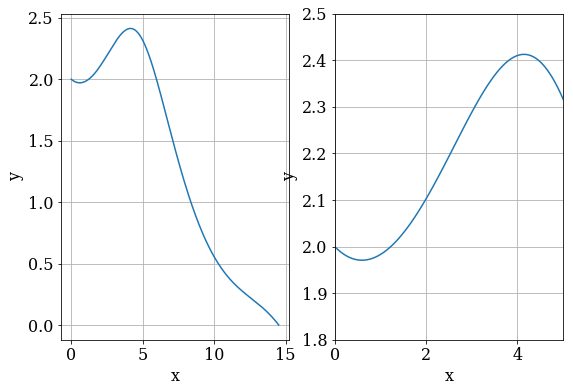

In [20]:
print('Distance traveled: {:.3f}'.format(x_leapfrog[idx_ground_leapfrog - 1]))

# Plot the glider's path for the leapfrog scheme.
pyplot.figure(figsize=(9.0, 6.0))
pyplot.subplot(121)
pyplot.grid()
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.plot(x_leapfrog[:idx_ground_leapfrog],
            y_leapfrog[:idx_ground_leapfrog])
# Let's take a closer look!
pyplot.subplot(122)
pyplot.grid()
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.plot(x_leapfrog, y_leapfrog)
pyplot.xlim(0.0, 5.0)
pyplot.ylim(1.8, 2.5);

What about the observed order of convergence? We'll repeat the process we have used before, with a grid-refinement ratio $r=2$ ... here we go:

In [21]:
r = 2  # time-step size refinement ratio
h = 0.001  # finest time-step size

dt_values = [h, r * h, r**2 * h]
u_values = []

for dt in dt_values:
    N = int(T / dt) + 1  # number of time steps
    # Set initial conditions.
    u = numpy.empty((N, 4))
    u[0] = numpy.array([v0, theta0, x0, y0])
    # Use RK2 for the first time step.
    u[1] = rk2_step(u[0], rhs_phugoid, dt, CL, CD, g, vt)
    # Time integration using the leapfrog scheme.
    for n in range(1, N - 1):
        u[n + 1] = leapfrog_step(u[n - 1], u[n], rhs_phugoid, dt,
                                 CL, CD, g, vt)
    # Store the solution for the present time grid.
    u_values.append(u)

# Compute the observed order of convergence.
p = (math.log(l1_diff(u_values[2][:, 2], u_values[1][:, 2],
                      dt_values[2]) /
              l1_diff(u_values[1][:, 2], u_values[0][:, 2],
                      dt_values[1])) /
     math.log(r))

print('Observed order of convergence: p = {:.3f}'.format(p))

Observed order of convergence: p = 2.187


We now have numerical evidence that our calculation with the leapfrog method indeed exhibits second-order convergence, i.e., the method is ${\mathcal O}(\Delta t^2)$. _The leapfrog method is a second-order method_. Good job!

### But chew on this ...

Go back to the cell that re-enters the model parameters, just above the leapfrog-method time loop, and change the following: the initial height `y0` to 25, and the final time `T` to 36. Now re-run the leapfrog calculation and the two code cells below that, which extract the glider's position and plot it.

_What is going on?_


## Reference

Tobies, R. "Iris Runge: A life at the crossroads of mathematics, science and industry," Springer Basel, 1st ed. (2012). [Read on Google books, page 73](http://books.google.com/books?id=EDm0eQqFUQ4C&lpg=PA73&dq=%22I%20have%20been%20making%20good%20progress%20with%20Lanchester.%20The%20second%20chapter%20is%20already%20on%20your%20desk%22&pg=PA73#v=onepage&q=%22I%20have%20been%20making%20good%20progress%20with%20Lanchester.%20The%20second%20chapter%20is%20already%20on%20your%20desk%22&f=false).

---

###### The cell below loads the style of the notebook.

In [22]:
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, 'r').read())